# Stock Price Prediction using Machine Learning

As of general knowledge, stock market prices are unstable and unpredictable due to the many parameters that they are based on. Only a few of these parameters can be modeled in a mathematical way, making the prediction of stock prices using machine learning challenging and unreliable.

Despite this difficulties, it is possible to predict short-term fluctuations in the market for an average and uneventful day, using enough historical data and useful features to develop a machine learning model.

If we treat the stock data as a time-series data, we can use past stock prices to predict the prices in the next day or week. LSTM (Long Short-Term Memory) is often used to model this type of problem. We are going to weigh out the importance of older and recent data and determine which parameters affect the next day prices the most.

### Implementation of the code

We will implement a simple LSTM network using TensorFlow Keras. We can work with actual stock prices dataset from major companies such as Microsoft, Apple or Facebook by downloading the data from [finances.yahoo.com](finances.yahoo.com).

We are going to download the Netflix (NFLX) stock over 3 years. This dataset will be a .csv document containing data for Open, High, Low, Close, Adj Close and Volume for each date.


### Downloading, analyzing and plotting the dataset

Having the dataset on hands, we will import the file as a DataFrame using Pandas, with each row representing data from a different date. 

In [1]:
import pandas as pd
stock_data = pd.read_csv('NFLX (3).csv', index_col = 'Date')
stock_data.head()
stock_data.shape

(757, 6)

We can now plot the High and Low points of Netflix stocks over the last 3 years:

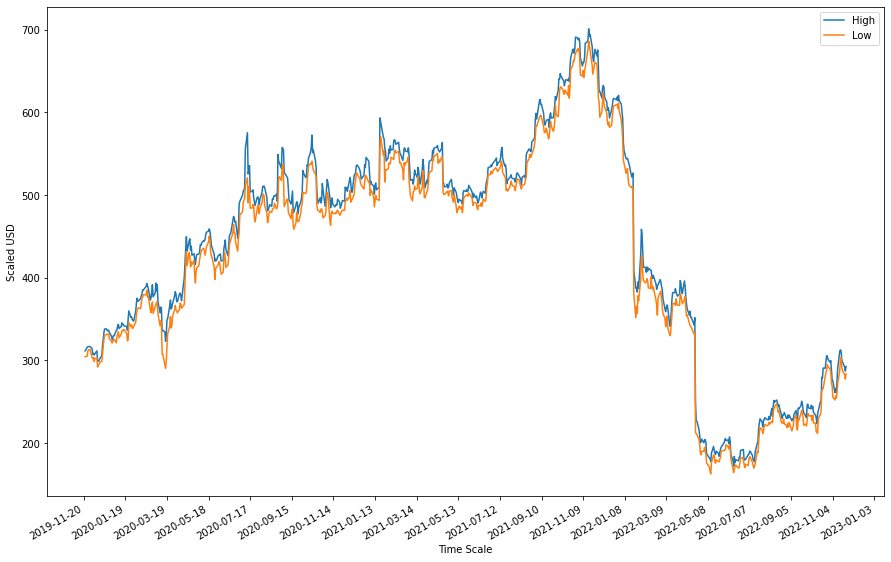

In [2]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime as dt

plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))
x_dates = [dt.datetime.strptime(d, '%Y-%m-%d').date() for d in stock_data.index.values]

plt.plot(x_dates, stock_data['High'], label = 'High')
plt.plot(x_dates, stock_data['Low'], label = 'Low')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

Using the same logic, we can plot the Open and Close values of the stock for each day:

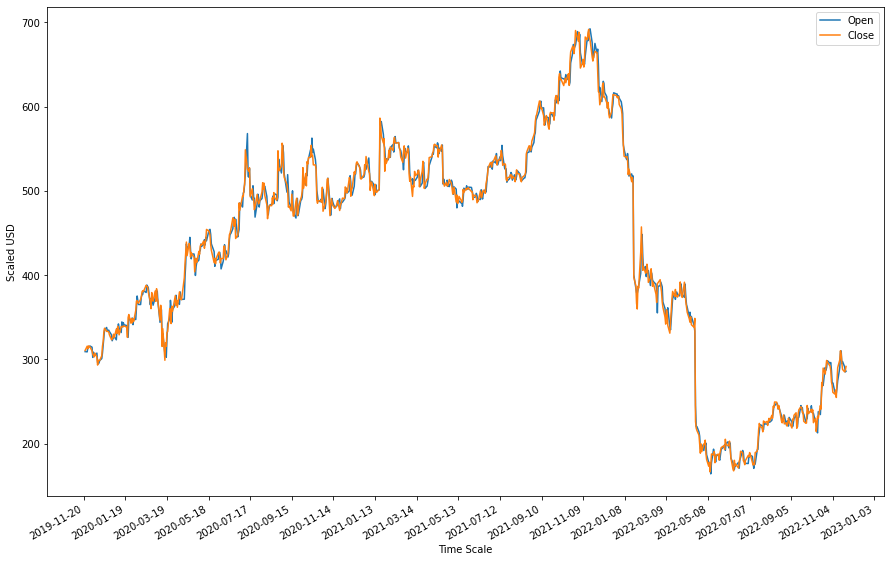

In [3]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime as dt

plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))
x_dates = [dt.datetime.strptime(d, '%Y-%m-%d').date() for d in stock_data.index.values]

plt.plot(x_dates, stock_data['Open'], label = 'Open')
plt.plot(x_dates, stock_data['Close'], label = 'Close')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

### Importing the Libraries

We will build our LSTM models using TensorFlow Keras and preprocessing our data using scikit-learn. 

In [4]:
%pip install -q tensorflow

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit 

### Data Preprocessing

We will now normalize the data within a fixed range to avoid features with larger numeric values to unjustly interfere and bias the model and help achieve rapid convergence.

First of all, we will define the features and the target. Then, we will use a StandardScaler to rescale our values between -1 and 1.

In [6]:
target_y = stock_data['Close']
X_feat = stock_data.iloc[:,0:3]

sc = StandardScaler()
X_ft = sc.fit_transform(X_feat.values)
X_ft = pd.DataFrame(columns = X_feat.columns, data = X_ft, index = X_feat.index)

X_ft


,Open,High,Low
Date,,,
2019-11-22,-0.904371,-0.934262,-0.894178
2019-11-25,-0.906383,-0.902121,-0.887864
2019-11-26,-0.860391,-0.896405,-0.839458
2019-11-27,-0.868367,-0.894030,-0.831491
2019-11-29,-0.854577,-0.895514,-0.827056
...,...,...,...
2022-11-17,-1.011562,-1.020220,-0.994974
2022-11-18,-0.992106,-1.033730,-1.025040
2022-11-21,-1.039291,-1.079233,-1.057662


Now, we can see that the actual dataframe is normalized and possesses 757 data samples.

The next step would be to split our dataset into training and testing sets. The LSTM model requires a different approach to this splitting phase than the train_test_split method provided by scikit-learn.

For this step, we will create a function called lstm_split, which takes the entire data and creates windows of size n_steps, starting from the beggining.

In [7]:
def lstm_split(data, n_steps):
  X, y = [], []
  for i in range(len(data)-n_steps+1):
    X.append(data[i:i + n_steps, :-1])
    y.append(data[i + n_steps-1, -1])

  return np.array(X), np.array(y)

### Train and Test sets for Stock Price Prediction

We split our data into training and testing sets. Shuffling is not permitted in time-series datasets. In the beginning, we take two steps worth of past data to predict the current value. Thus, the model will look at yesterday’s and today’s values to predict today’s closing price.



In [8]:
X1, y1 = lstm_split(X_ft.values, n_steps=2)

train_split=0.8
split_idx = int(np.ceil(len(X1)*train_split))
date_index = X_ft.index

X_train, X_test = X1[:split_idx], X1[split_idx:]
y_train, y_test = y1[:split_idx], y1[split_idx:]
X_train_date, X_test_date = date_index[:split_idx], date_index[split_idx:]
X_test_date_shaped = X_test_date.tolist()
X_test_date_shaped.pop()

print(X1.shape, X_train.shape, X_test.shape, y_test.shape)

(756, 2, 2) (605, 2, 2) (151, 2, 2) (151,)


### Building the LSTM model

We will use the Sequential and LSTM modules provided by Tensorflow Keras to build a simple, single-unit LSTM model.

In [9]:
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences=True))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 32)             4480      
                                                                 
 dense (Dense)               (None, 2, 1)              33        
                                                                 
Total params: 4,513
Trainable params: 4,513
Non-trainable params: 0
_________________________________________________________________


Now, we can fit a simple model to the training data:

In [10]:
history=lstm.fit(X_train, y_train, epochs=100, batch_size=4, verbose=2, shuffle=False)

Epoch 1/100
152/152 - 2s - loss: 0.2797 - 2s/epoch - 14ms/step
Epoch 2/100
152/152 - 0s - loss: 0.1081 - 381ms/epoch - 3ms/step
Epoch 3/100
152/152 - 0s - loss: 0.0406 - 438ms/epoch - 3ms/step
Epoch 4/100
152/152 - 0s - loss: 0.0230 - 402ms/epoch - 3ms/step
Epoch 5/100
152/152 - 0s - loss: 0.0179 - 337ms/epoch - 2ms/step
Epoch 6/100
152/152 - 0s - loss: 0.0141 - 368ms/epoch - 2ms/step
Epoch 7/100
152/152 - 0s - loss: 0.0128 - 374ms/epoch - 2ms/step
Epoch 8/100
152/152 - 0s - loss: 0.0127 - 359ms/epoch - 2ms/step
Epoch 9/100
152/152 - 0s - loss: 0.0128 - 353ms/epoch - 2ms/step
Epoch 10/100
152/152 - 0s - loss: 0.0129 - 350ms/epoch - 2ms/step
Epoch 11/100
152/152 - 0s - loss: 0.0130 - 332ms/epoch - 2ms/step
Epoch 12/100
152/152 - 0s - loss: 0.0131 - 364ms/epoch - 2ms/step
Epoch 13/100
152/152 - 0s - loss: 0.0133 - 352ms/epoch - 2ms/step
Epoch 14/100
152/152 - 1s - loss: 0.0135 - 509ms/epoch - 3ms/step
Epoch 15/100
152/152 - 1s - loss: 0.0137 - 581ms/epoch - 4ms/step
Epoch 16/100
152/152 

### Performance Evaluation on Test Set

In [11]:
y_pred = lstm.predict(X_test)
y_pred = y_pred[:,0,0]

5/5 [==============================] - 0s 3ms/step


In [12]:
y_pred

array([-1.3005636 , -1.4760034 , -1.4778597 , -1.5323687 , -1.575577  ,
       -1.6784873 , -1.6899126 , -1.6422218 , -1.6917632 , -1.6475776 ,
       -1.6488128 , -1.6403216 , -1.7481642 , -1.8105737 , -1.8233013 ,
       -1.8248887 , -1.9052918 , -1.8036603 , -1.6915843 , -1.7250881 ,
       -1.7472984 , -1.8015475 , -1.7469976 , -1.7507355 , -1.7830645 ,
       -1.782784  , -1.7387905 , -1.6935626 , -1.6664549 , -1.6461743 ,
       -1.6786807 , -1.6374831 , -1.6244359 , -1.674746  , -1.640789  ,
       -1.6371559 , -1.7752838 , -1.8230098 , -1.8824325 , -1.8593771 ,
       -1.8475533 , -1.8423841 , -1.8208642 , -1.8527318 , -1.7946312 ,
       -1.7588062 , -1.7091066 , -1.7232223 , -1.8047924 , -1.8222277 ,
       -1.8242809 , -1.812901  , -1.7593992 , -1.7563645 , -1.7467117 ,
       -1.7647988 , -1.8199577 , -1.8622215 , -1.8354635 , -1.8098484 ,
       -1.6883142 , -1.6804686 , -1.5631509 , -1.5140295 , -1.4596876 ,
       -1.4737827 , -1.5110731 , -1.4949393 , -1.4501348 , -1.45

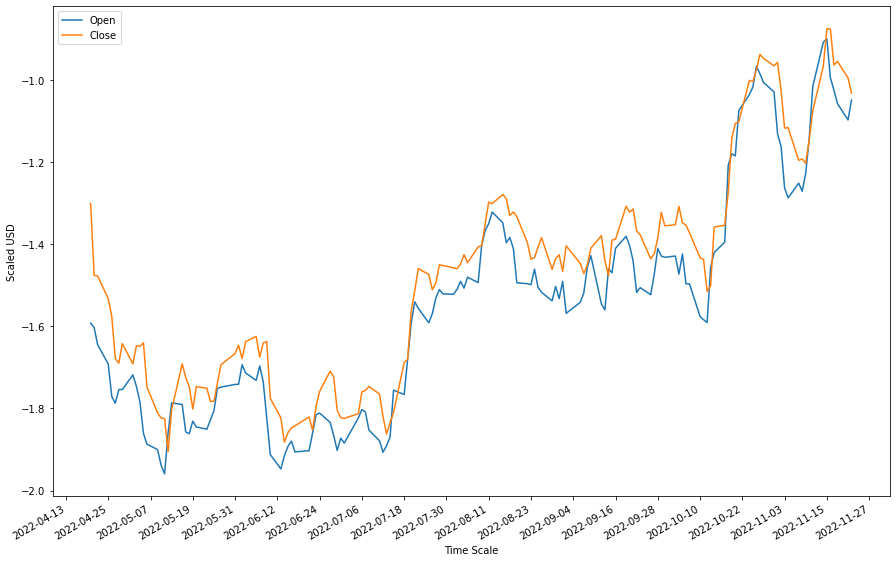

In [13]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=12))
X_test_date_axis = [dt.datetime.strptime(d, '%Y-%m-%d').date() for d in X_test_date_shaped]

plt.plot(X_test_date_axis, y_test, label = 'Open')
plt.plot(X_test_date_axis, y_pred, label = 'Close')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()


In [14]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)
print("RSME: ", rmse)
print("MAPE: ", mape)

RSME:  0.0937818015920307
MAPE:  0.05153900530607854


In [15]:
lstm2 = Sequential()
lstm2.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences=True))
lstm2.add(LSTM(50, activation='relu'))
lstm2.add(Dense(1))
lstm2.compile(loss='mean_squared_error', optimizer='adam')
lstm2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 2, 50)             10600     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30,851
Trainable params: 30,851
Non-trainable params: 0
_________________________________________________________________


In [16]:
history2 = lstm2.fit(X_train, y_train, epochs=100, batch_size=4, verbose=2, shuffle=False)

Epoch 1/100
152/152 - 3s - loss: 0.1578 - 3s/epoch - 18ms/step
Epoch 2/100
152/152 - 1s - loss: 0.0210 - 533ms/epoch - 4ms/step
Epoch 3/100
152/152 - 1s - loss: 0.0088 - 555ms/epoch - 4ms/step
Epoch 4/100
152/152 - 1s - loss: 0.0087 - 568ms/epoch - 4ms/step
Epoch 5/100
152/152 - 1s - loss: 0.0084 - 537ms/epoch - 4ms/step
Epoch 6/100
152/152 - 1s - loss: 0.0080 - 542ms/epoch - 4ms/step
Epoch 7/100
152/152 - 1s - loss: 0.0077 - 565ms/epoch - 4ms/step
Epoch 8/100
152/152 - 1s - loss: 0.0073 - 564ms/epoch - 4ms/step
Epoch 9/100
152/152 - 1s - loss: 0.0071 - 570ms/epoch - 4ms/step
Epoch 10/100
152/152 - 1s - loss: 0.0067 - 529ms/epoch - 3ms/step
Epoch 11/100
152/152 - 1s - loss: 0.0066 - 561ms/epoch - 4ms/step
Epoch 12/100
152/152 - 1s - loss: 0.0063 - 545ms/epoch - 4ms/step
Epoch 13/100
152/152 - 1s - loss: 0.0060 - 549ms/epoch - 4ms/step
Epoch 14/100
152/152 - 1s - loss: 0.0058 - 543ms/epoch - 4ms/step
Epoch 15/100
152/152 - 1s - loss: 0.0056 - 533ms/epoch - 4ms/step
Epoch 16/100
152/152 

In [17]:
y_pred2 = lstm2.predict(X_test)

5/5 [==============================] - 0s 3ms/step


In [18]:
y_pred2

array([[-1.4825414 ],
       [-1.1747975 ],
       [-1.270369  ],
       [-1.2246658 ],
       [-1.2747148 ],
       [-1.0711428 ],
       [-0.999678  ],
       [-1.1626806 ],
       [-1.0006918 ],
       [-1.0791911 ],
       [-1.093027  ],
       [-1.2624379 ],
       [-1.0838677 ],
       [-0.9772674 ],
       [-0.9537463 ],
       [-1.0401063 ],
       [-0.7541182 ],
       [-0.83277476],
       [-1.1048911 ],
       [-1.0628766 ],
       [-1.0651205 ],
       [-0.9020691 ],
       [-1.0251255 ],
       [-1.0508286 ],
       [-0.953346  ],
       [-0.93044734],
       [-0.9609922 ],
       [-0.99775684],
       [-1.035073  ],
       [-1.1051726 ],
       [-1.0447139 ],
       [-1.0681015 ],
       [-1.1666796 ],
       [-0.99538386],
       [-1.1165948 ],
       [-1.312322  ],
       [-1.0638038 ],
       [-1.0304415 ],
       [-0.8132036 ],
       [-0.9563792 ],
       [-0.8976183 ],
       [-0.91433024],
       [-0.9521289 ],
       [-0.8793042 ],
       [-0.8939724 ],
       [-0

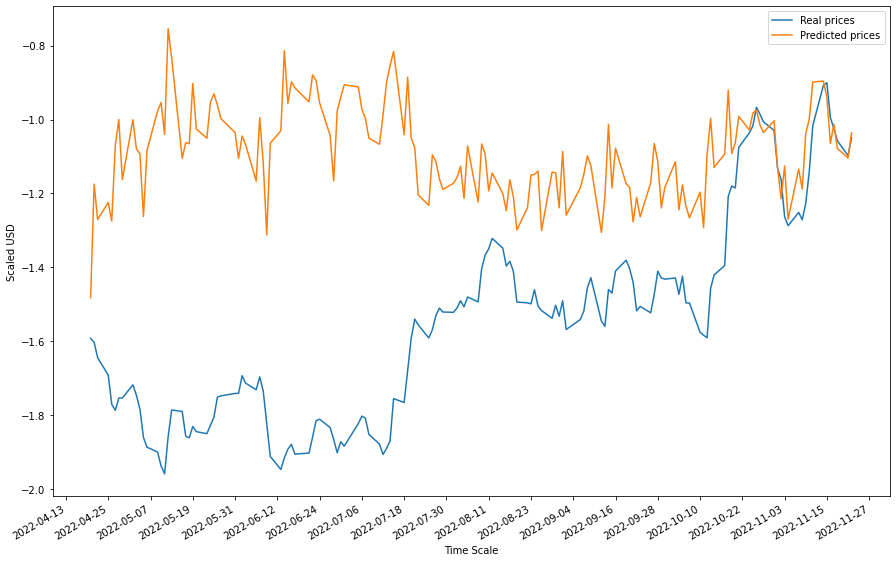

In [19]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=12))
X_test_date_axis = [dt.datetime.strptime(d, '%Y-%m-%d').date() for d in X_test_date_shaped]

plt.plot(X_test_date_axis, y_test, label = 'Real prices')
plt.plot(X_test_date_axis, y_pred2, label = 'Predicted prices')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()


In [20]:
rmse = mean_squared_error(y_test, y_pred2, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred2)
print("RSME: ", rmse)
print("MAPE: ", mape)

RSME:  0.5601415561085653
MAPE:  0.2747776416407897
